# YT 2020: MBO Testing

Перепроверить расчеты можно тут https://yt.yandex-team.ru/hahn/resource-planner/ 

In [1]:
import sys, os, re, logging
from pathlib import Path
import pandas as pd
import numpy as np
from pprint import pformat

%matplotlib inline

cwd = os.getcwd()
preorder_key = max(re.findall(r"(preorder/v\d+)", cwd))
capacity_path = Path(cwd[:cwd.rfind(preorder_key)])
sys.path.extend([str(capacity_path),
                 str(capacity_path / preorder_key),
                 str(capacity_path / ("../" * 4))])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [4]:
from market.sre.tools.capacity.lib.YT.Cluster import Cluster
from market.sre.tools.capacity.lib.tools import today
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.predictor import Formula, Feature, FormulaStrategy, Predictor, Window
from market.sre.tools.capacity.preorder.v2020.input_data.forecast_options import forecast_end_date
from market.sre.tools.capacity.preorder.v2020.input_data.YT_accounts import arnold_accounts, hahn_accounts, seneca_sas_accounts, seneca_man_accounts, seneca_vla_accounts
from market.sre.tools.capacity.preorder.v2020.input_data.YT_pools import hahn_pools_list, hahn_pools_dict, arnold_pools_list, arnold_pools_dict
from market.sre.tools.capacity.preorder.v2020.additional.YT.disk_forecaster import get_disk_forecast
from market.sre.tools.capacity.preorder.v2020.additional.YT.cpu_forecaster import get_cpu_forecast
from market.sre.tools.capacity.preorder.v2020.preorder_lib.yt.yt_order import YTOrderRequestFile, YTOrderRequestFileItem, YtOrderRequestFileItemDiskQuota, YtOrderRequestFileItemCpuQuota, YtOrderRequestFileItemDTQuota
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.types.department import Department
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.department_info import DepartmentInfo
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.types.cloud import Cloud
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.types.reason import Reason
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.types.deadline import Deadline
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.types.platform import Platform
from market.sre.tools.capacity.preorder.v2020.preorder_lib.core.resources_info import ResourcesInfo
from market.sre.tools.capacity.preorder.v2020.additional.YT.tools import clean_YT_account

## Настройки

In [5]:
# откуда смотреть историю потребления
date_start = today(minus_days=365, astype=str)
date_end = today(minus_days=1, astype=str)

# учитывать ли пики в пуле?
consider_peaks = False

# verbose
verbose = True

# grid
grid=True

tail_depth = 7
quantile = .8

# formula
formula = None

# formula stratery
formula_strategy = FormulaStrategy.FIRST

# настройки Predictor'а
decreasing_base_function = 'mean'
decreasing_reserve = 1.5
features = [Feature.OFFERS_COUNT]

# defaults
default_platform = Platform.INFRA
default_department = Department.MBO

In [6]:
notebook_filename = f"https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/{preorder_key}/additional/YT/calculations/mbo_testing.ipynb"
notebook_filename

'https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/preorder/v2020/additional/YT/calculations/mbo_testing.ipynb'

In [7]:
whois = ResourcesInfo(capacity_path / preorder_key / "input_data/files/whois", default_platform=default_platform, default_department=default_department)

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

grid = True

In [9]:
predictor = Predictor()

### Env

In [10]:
env = 'production' # не продакшен будем смотреть

## Disk

#### Accounts

In [11]:
label = 'mbo'

_hahn_accounts = [account for account in hahn_accounts if label in account and account not in [account for account in hahn_accounts if label in account and env in account]]
_arnold_accounts = [account for account in arnold_accounts if label in account and account not in [account for account in arnold_accounts if label in account and env in account]]
_seneca_sas_accounts = [account for account in seneca_sas_accounts if label in account and account not in [account for account in seneca_sas_accounts if label in account and env in account]]
_seneca_man_accounts = [account for account in seneca_man_accounts if label in account and account not in [account for account in seneca_man_accounts if label in account and env in account]]
_seneca_vla_accounts = [account for account in seneca_vla_accounts if label in account and account not in [account for account in seneca_vla_accounts if label in account and env in account]]

cluster_accounts = {
    Cluster.HAHN: _hahn_accounts,
    Cluster.ARNOLD: _arnold_accounts,
    Cluster.SENECA_SAS: _seneca_sas_accounts,
    Cluster.SENECA_MAN: _seneca_man_accounts,
    Cluster.SENECA_VLA: _seneca_vla_accounts,
}

print(cluster_accounts)

{<Cluster.HAHN: 'hahn'>: ['market-mbo-development', 'market-mbo-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-mbo-development', 'market-mbo-testing'], <Cluster.SENECA_SAS: 'seneca-sas'>: [], <Cluster.SENECA_MAN: 'seneca-man'>: [], <Cluster.SENECA_VLA: 'seneca-vla'>: []}


##### Disk usage history and forecast, GB

HAHN DEFAULT usage: 19343 / 61440 Gb = 31.48 %


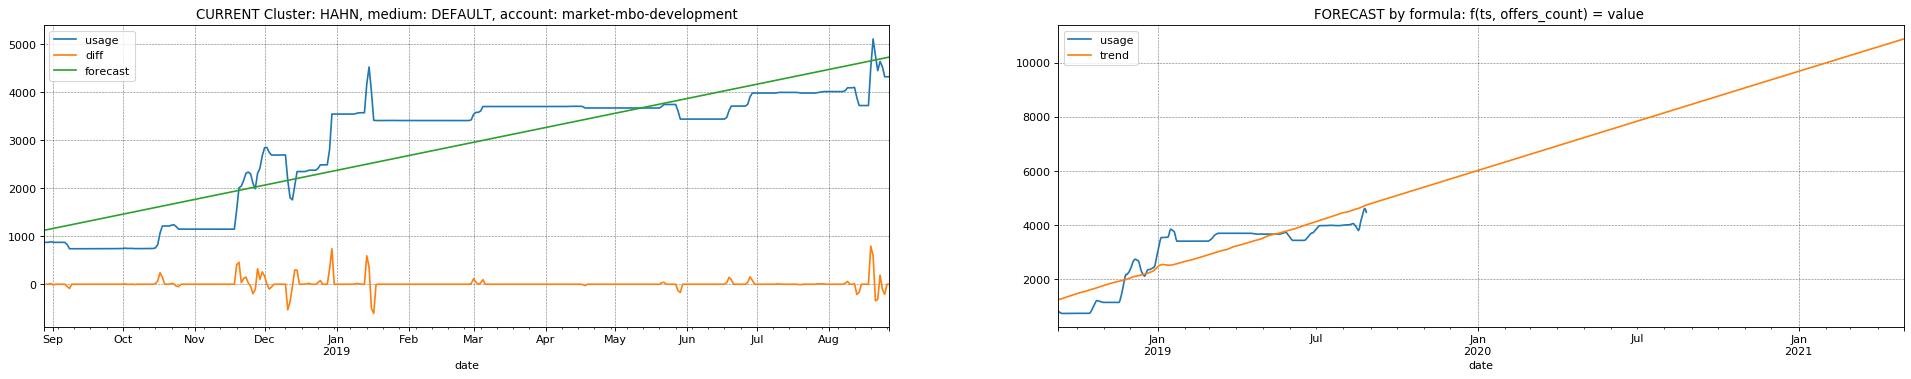

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.7646574172474848}


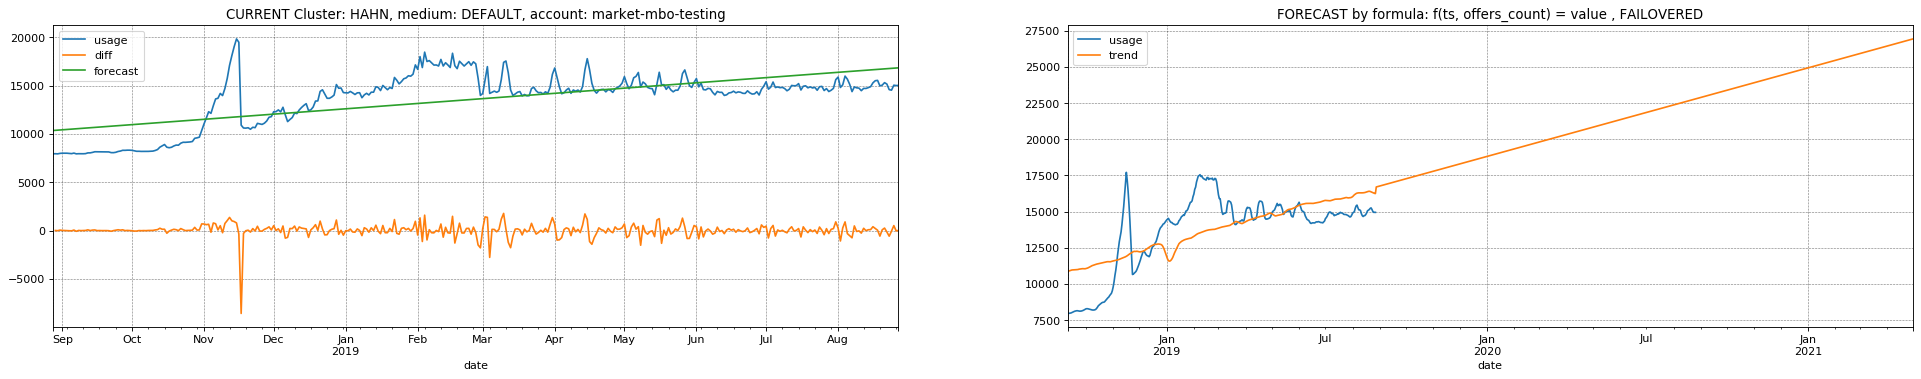

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.6254933400987639}


HAHN SSD usage: 8513 / 15360 Gb = 55.42 %


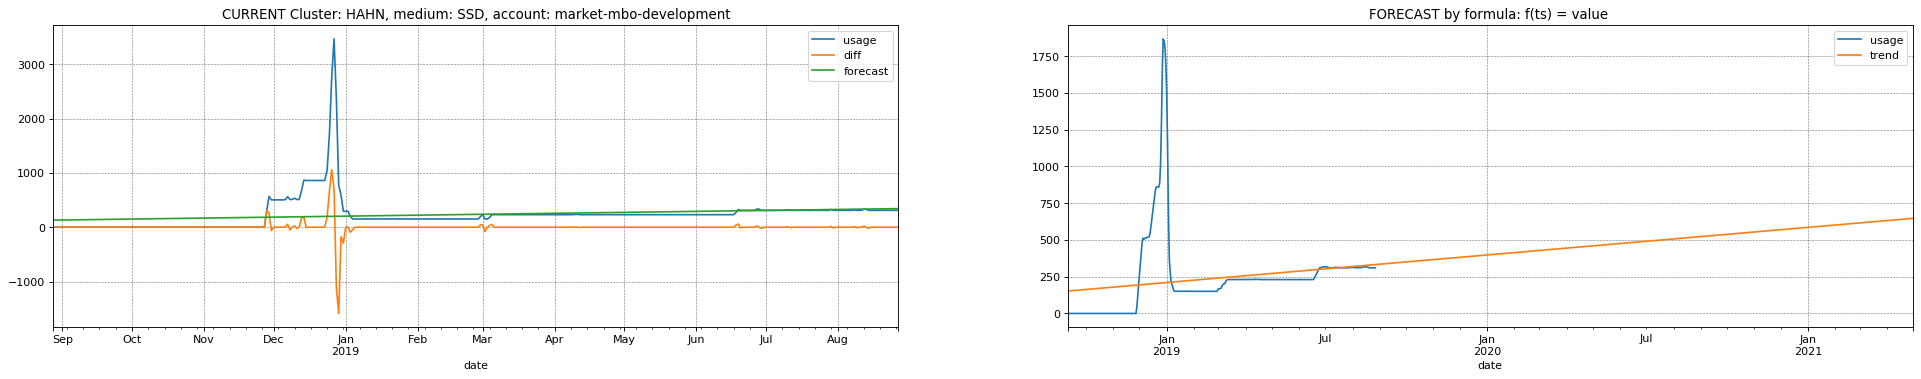

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.20608442912485503,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.10077782747428035}


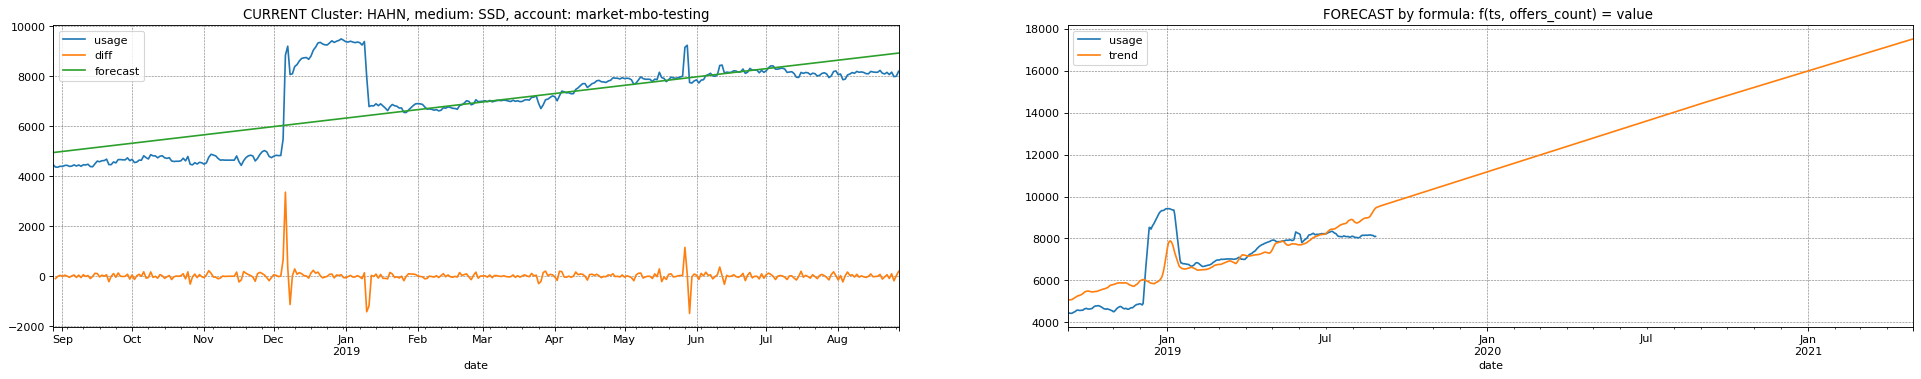

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.5617503482267822}


ARNOLD DEFAULT usage: 4658 / 61440 Gb = 7.58 %


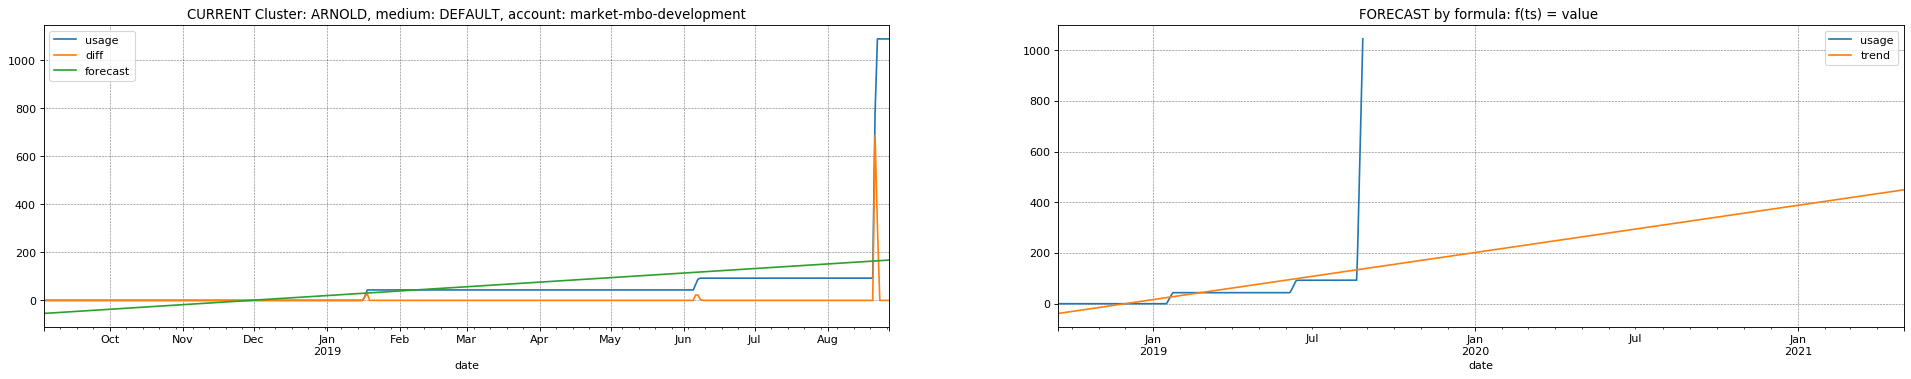

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.1265667784190188,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.38947008504702446}


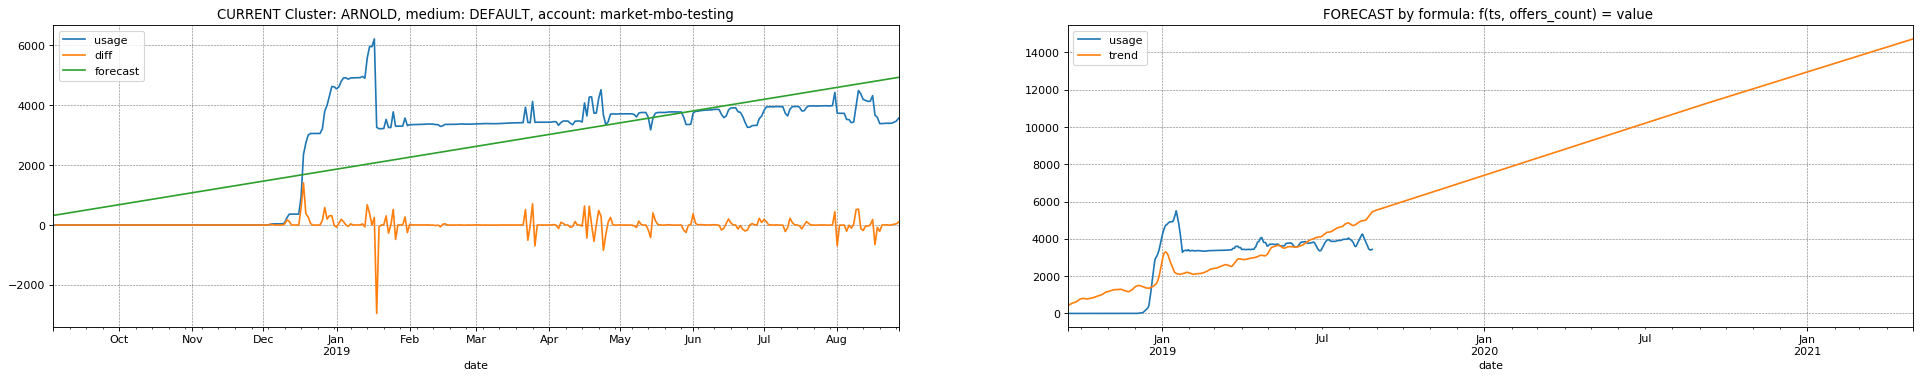

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.601326115788521}


ARNOLD SSD usage: 1 / 10240 Gb = 0.01 %


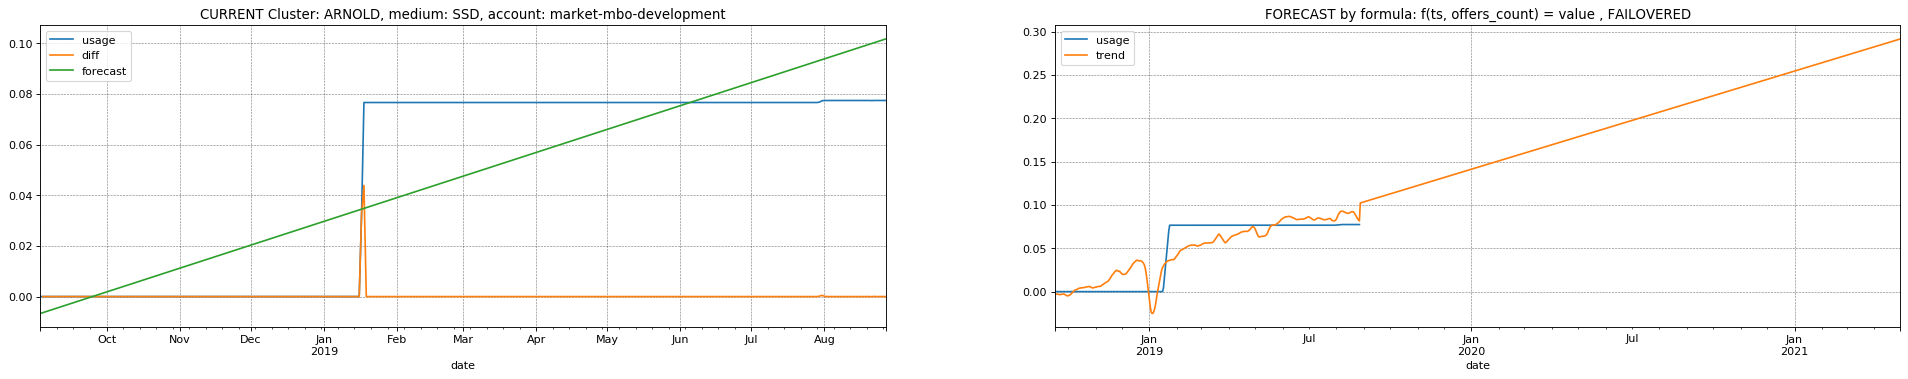

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.8804553177810773}


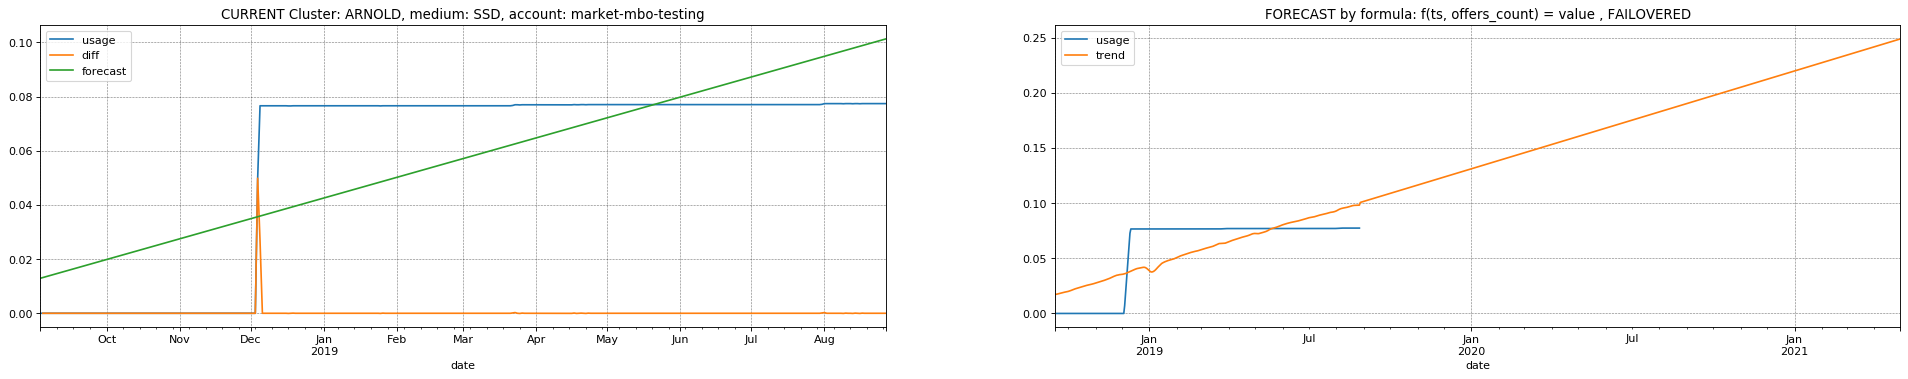

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.6781297398681132}


In [12]:
disk_forecast = get_disk_forecast(predictor=predictor,
                                  formula=formula,
                                  formula_strategy=formula_strategy,
                                  features=features,
                                  window=Window(),
                                  decreasing_base_function=decreasing_base_function,
                                  decreasing_reserve=decreasing_reserve,
                                  cluster_accounts=cluster_accounts,
                                  date_start=date_start,
                                  date_end=date_end,
                                  verbose=verbose,
                                  grid=grid)

In [13]:
disk_forecast_df = pd.DataFrame(disk_forecast).set_index(['cluster', 'account', 'medium'])
disk_forecast_df

predicted_usage_gb  quota_gb  \
cluster account                medium                                  
HAHN    market-mbo-development DEFAULT               10880     30720   
        market-mbo-testing     DEFAULT               26941     30720   
        market-mbo-development SSD                     648      5120   
        market-mbo-testing     SSD                   17500     10240   
ARNOLD  market-mbo-development DEFAULT                 449     30720   
        market-mbo-testing     DEFAULT               14718     30720   
        market-mbo-development SSD                       1      5120   
        market-mbo-testing     SSD                       1      5120   

                                            reason  usage_gb  
cluster account                medium                         
HAHN    market-mbo-development DEFAULT      OFFERS      4320  
        market-mbo-testing     DEFAULT      OFFERS     15024  
        market-mbo-development SSD      CUMULATIVE       311  
        market-mbo-testing     SSD          OFFERS      8203  
ARNOLD  market-mbo-development DEFAULT  CUMULATIVE      1088  
        market-mbo-testing     DEFAULT      OFFERS      3570  
        market-mbo-development SSD          OFFERS         1  
        market-mbo-testing     SSD          OFFERS         1

In [14]:
for key, value in disk_forecast_df.query("predicted_usage_gb > 0").iterrows():
    cluster, account, medium = key
    predicted_usage_gb = value.predicted_usage_gb
    quota_gb = value.quota_gb
    usage_gb = value.usage_gb
    reason = value.reason
    
    if medium == 'DEFAULT':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            hdd_quota_gb=quota_gb,
            hdd_usage_gb=usage_gb,
            predicted_hdd_usage_gb=predicted_usage_gb
        )
    elif medium == 'SSD':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            ssd_quota_gb=quota_gb,
            ssd_usage_gb=usage_gb,
            predicted_ssd_usage_gb=predicted_usage_gb
        )
    else:
        raise
    
    resource_info = whois.get_info(Cloud.YT, clean_YT_account(account))
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       disk_quota=disk_quota)
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket=notebook_filename,
        contacts=department_info.owners if department_info else [],
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/disk-{cluster}-{account}-{medium}.yaml")),
        reason=Reason.from_str(reason),
        generated=True).dump_to_file()

### CPU

In [15]:
label = 'mbo'

_hahn_pools_list = [pool for pool in hahn_pools_list if label in pool and env not in pool]
_arnold_pools_list = [pool for pool in arnold_pools_list if label in pool and env not in pool]

cluster_pools = {
    Cluster.HAHN: _hahn_pools_list,
    Cluster.ARNOLD: _arnold_pools_list
}

print(cluster_pools)

{<Cluster.HAHN: 'hahn'>: ['market-testing-mbo-extractors'], <Cluster.ARNOLD: 'arnold'>: ['market-testing-mbo-extractors']}


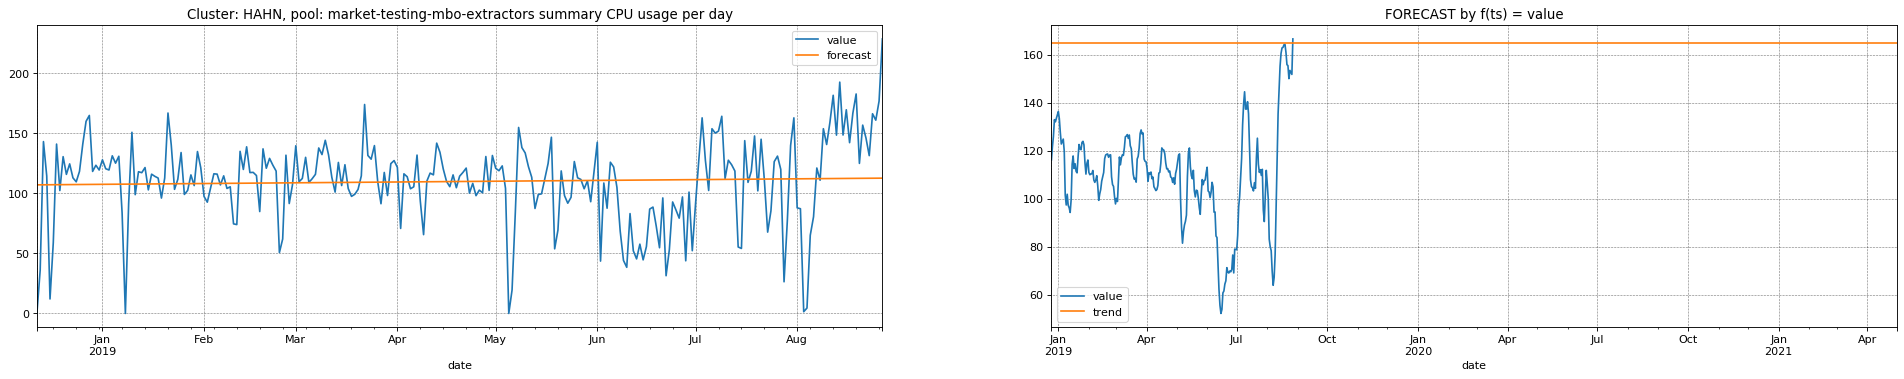

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.08682442297705714,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.1969625185097891}
Базовый прогноз: 164.88198490250352 ядер


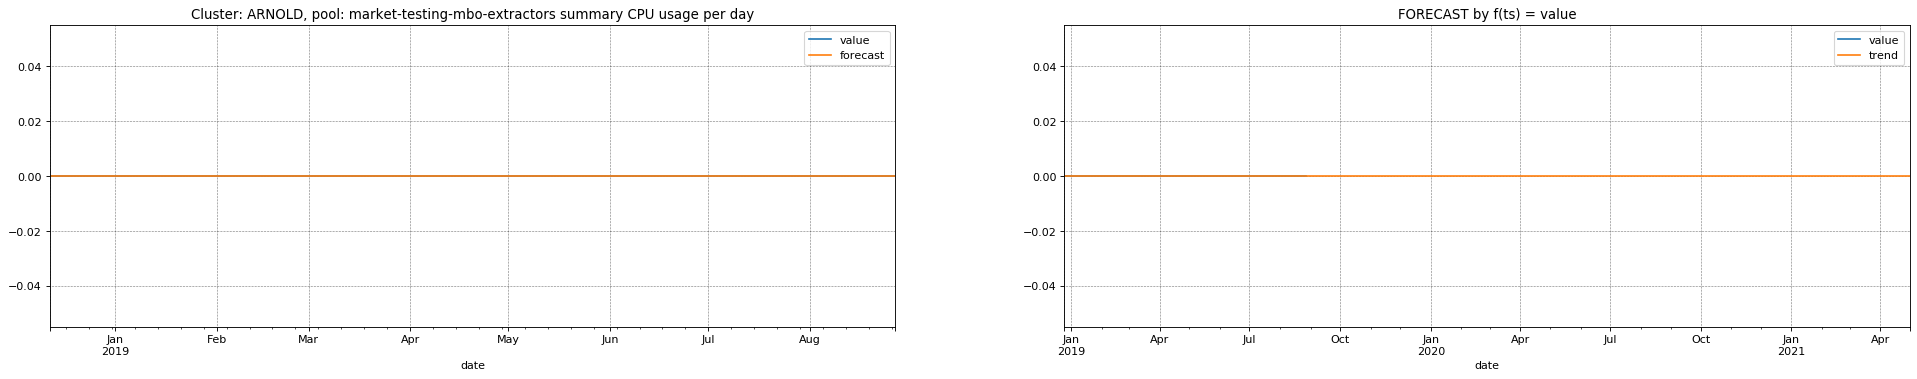

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}
Базовый прогноз: 0.0 ядер


In [16]:
cpu_forecast = get_cpu_forecast(predictor=predictor,
                                cluster_pools=cluster_pools,
                                formula=formula,
                                formula_strategy=formula_strategy,
                                features=features,
                                window=Window(),
                                decreasing_base_function=decreasing_base_function,
                                decreasing_reserve=decreasing_reserve,
                                consider_peaks=consider_peaks,
                                date_start=date_start,
                                date_end=date_end,
                                peaks_window_1=5,
                                peaks_window_2=60,
                                verbose=verbose,
                                grid=grid,
                                tail_depth=tail_depth,
                                quantile=quantile)

In [17]:
cpu_forecast_df = pd.DataFrame(cpu_forecast).set_index(['cluster', 'pool'])
cpu_forecast_df

,,peak_coef,predicted_usage,quota,reason,usage
cluster,pool,,,,,
HAHN,market-testing-mbo-extractors,1,165,0,CUMULATIVE,175
ARNOLD,market-testing-mbo-extractors,1,0,0,CUMULATIVE,0


In [18]:
for key, value in cpu_forecast_df.query("predicted_usage > 0").iterrows():
    cluster, pool = key
    predicted_usage = value.predicted_usage
    quota = value.quota
    usage = value.usage
    peak_coef = value.peak_coef
    reason = value.reason
    
    cpu_quota=YtOrderRequestFileItemCpuQuota(
        pools=[pool],
        cpu_quota=quota,
        cpu_usage=usage,
        predicted_cpu_usage=predicted_usage,
        cpu_peak_coef=peak_coef
    )
    
    resource_info = whois.get_info(Cloud.YT, pool)
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       cpu_quota=cpu_quota)
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket=notebook_filename,
        contacts=department_info.owners if department_info else [],
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(capacity_path / preorder_key / (f"input_data/orders/{resource_info['department']}/{Cloud.YT}/pool-{cluster}-{pool}.yaml")),
        reason=Reason.from_str(reason),
        generated=True).dump_to_file()